In [1]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as mdates

%matplotlib inline

/home/vitor/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Read porftolio function

In [2]:
def read_portfolio(filename):
    df = pd.read_csv(filename)
    
    row = df.iloc[0]
    
    portfolio = {
        'error': row['Error'],
        'weights': json.loads(row['Portfolio Weights']),
        'performance': {
            'train_performance': {
                'tracking_error': row['Train Tracking Error'],
                'root_mean_squared_error': row['Train RMSE'],
                'correlation': row['Train Correlation']
            },
            'test_performance': {
                'tracking_error': row['Test Tracking Error'],
                'root_mean_squared_error': row['Test RMSE'],
                'correlation': row['Test Correlation']
            }
        },
        'optimization_time': row['Optimization Time'],
        'dates': {
            'train': {
                'start': row['Start train'],
                'end': row['End train'],
            },
            'test': {
                'start': row['Start test'],
                'end': row['End test'],
            }
        }
    }
    return portfolio

## Plot functions

In [3]:
def plot_portfolio(portfolio, stocks_data, index_data, start_date, end_date, index_name, yaxis_name='Cumulative Returns'):
    test_start = portfolio['dates']['test']['start']
    test_end = portfolio['dates']['test']['end']
    train_start = portfolio['dates']['train']['start']
    train_end = portfolio['dates']['train']['end']
    portfolio_weights = portfolio['weights']
    
    selected_stocks = stocks_data.columns
    portfolio_data = stocks_data[selected_stocks]
    weights = pd.Series(portfolio_weights).reindex(selected_stocks).values
    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:end_date]
    index_data_filtered = index_data.loc[start_date:end_date]


    fig = plt.figure(figsize=(15, 8), facecolor='black')
    axis = fig.add_axes([0, 0, 1, 1], facecolor='black')

    # Plot the index and portfolio lines
    axis.plot(index_data_filtered.index, index_data_filtered, color='red', linestyle='-', linewidth=3, label=index_name)
    axis.plot(portfolio_data_filtered.index, portfolio_data_filtered, color='gold', linestyle='--', linewidth=2, label="Portfolio")

    axis.axvline(x=test_start, color='white', linestyle='--', linewidth=2, label='Test Start')
    axis.text(test_start, axis.get_ylim()[1], 'Test Start', 
              rotation=90, verticalalignment='top', 
              horizontalalignment='right', 
              color='white', fontsize=12)
    axis.set_xticks(index_data_filtered.index[::30])

    axis.set_title(f"Portfolio {len(portfolio_weights)} stocks {index_name}: {start_date} to {end_date}", fontsize=25, pad=20, color='white')
    axis.legend(title="Indicator", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')

    axis.set_ylabel(yaxis_name, fontsize=20, color='white')
    axis.set_xlabel('Date', fontsize=20, color='white')
    axis.tick_params(colors='white')
    axis.grid(color='gray', linestyle='--')

    plt.show()

In [4]:
def plot_portfolio_rebalance(portfolio, portfolio_rebalance, stocks_data, index_data, start_date, end_date, index_name, yaxis_name='Cumulative Returns'):
    test_start = portfolio['dates']['test']['start']
    test_end = portfolio['dates']['test']['end']
    train_start = portfolio['dates']['train']['start']
    train_end = portfolio['dates']['train']['end']
    portfolio_weights = portfolio['weights']
    
    test_rebalance_start = portfolio_rebalance['dates']['test']['start']
    test_rebalance_end = portfolio_rebalance['dates']['test']['end']
    train_rebalance_start = portfolio_rebalance['dates']['train']['start']
    train_rebalance_end = portfolio_rebalance['dates']['train']['end']
    portfolio_rebalance_weights = portfolio_rebalance['weights']
    
    selected_stocks = stocks_data.columns
    index_data_filtered = index_data.loc[start_date:end_date]
    
    portfolio_data = stocks_data[selected_stocks]
    weights = pd.Series(portfolio_weights).reindex(selected_stocks).values
    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:test_rebalance_start]

    portfolio_rebalance_data = stocks_data[selected_stocks]
    weights_rebalance = pd.Series(portfolio_weights).reindex(selected_stocks).values
    portfolio_rebalance_data_filtered = (portfolio_rebalance_data * weights_rebalance).sum(axis=1).loc[test_rebalance_start:end_date]

    full_portfolio_data_filtered = pd.concat([portfolio_data_filtered, portfolio_rebalance_data_filtered])

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    axis = fig.add_axes([0, 0, 1, 1], facecolor='black')

    # Plot the index and portfolio lines
    axis.plot(index_data_filtered.index, index_data_filtered, color='red', linestyle='-', linewidth=3, label=index_name)
    axis.plot(full_portfolio_data_filtered.index, portfolio_data_filtered, color='gold', linestyle='--', linewidth=2, label="Portfolio")

    axis.axvline(x=test_start, color='white', linestyle='--', linewidth=2, label='Test Start')
    axis.text(test_start, axis.get_ylim()[1], 'Test Start', 
              rotation=90, verticalalignment='top', 
              horizontalalignment='right', 
              color='white', fontsize=12)
    axis.set_xticks(index_data_filtered.index[::30])
    
    axis.axvline(x=train_start_rebalance, color='white', linestyle='--', linewidth=2, label='Test Start')
    axis.text(train_start_rebalance, axis.get_ylim()[1], 'Rebalance Start', 
              rotation=90, verticalalignment='top', 
              horizontalalignment='right', 
              color='white', fontsize=12)
    
    axis.axvline(x=train_end_rebalance, color='white', linestyle='--', linewidth=2, label='Test Start')
    axis.text(train_end_rebalance, axis.get_ylim()[1], 'Rebalance End', 
              rotation=90, verticalalignment='top', 
              horizontalalignment='right', 
              color='white', fontsize=12)

    axis.set_title(f"Portfolio {len(portfolio_weights)} stocks {index_name}: {start_date} to {end_date}", fontsize=25, pad=20, color='white')
    axis.legend(title="Indicator", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')

    axis.set_ylabel(yaxis_name, fontsize=20, color='white')
    axis.set_xlabel('Date', fontsize=20, color='white')
    axis.tick_params(colors='white')
    axis.grid(color='gray', linestyle='--')

    plt.show()

In [5]:
def plot_weights(portfolio):
    labels = list(portfolio.keys())
    values = list(portfolio.values())

    colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')

    squarify.plot(
        sizes=values,
        label=labels,
        alpha=0.8,
        color=colors,
        text_kwargs={'color': 'white', 'fontsize': 12}
    )

    plt.title(f"Treemap {len(portfolio)} stocks SP100", fontsize=18, color='white', pad=20)
    plt.axis('off')
    plt.show()



## Loading data

In [6]:
bvsp_index_ticker = '^BVSP'

bvsp_data_values = pd.read_csv('../data/stock_cumulative_returns_^BVSP.csv', index_col=0)  # Inclui o índice
bvsp_data_variance = pd.read_csv('../data/stock_variance_^BVSP.csv', index_col=0)

bvsp_index_values = bvsp_data_values[bvsp_index_ticker]
bvsp_stocks_values = bvsp_data_values.drop(columns=[bvsp_index_ticker])

bvsp_index_variance = bvsp_data_variance[bvsp_index_ticker]
bvsp_stock_variance = bvsp_data_variance.drop(columns=[bvsp_index_ticker])

sp100_index_ticker = '^OEX'

sp100_data_values = pd.read_csv('../data/stock_cumulative_returns_^OEX.csv', index_col=0)  # Inclui o índice
sp100_data_variance = pd.read_csv('../data/stock_variance_^OEX.csv', index_col=0)

sp100_index_values = sp100_data_values[sp100_index_ticker]
sp100_stocks_values = sp100_data_values.drop(columns=[sp100_index_ticker])

sp100_index_variance = sp100_data_variance[sp100_index_ticker]
sp100_stock_variance = sp100_data_variance.drop(columns=[sp100_index_ticker])

start_date_dataset = "2023-01-01"
end_date_dataset = "2023-12-31"
train_start = start_date_dataset
train_end = "2023-03-31"
test_start = "2023-04-01"
test_end = end_date_dataset

start_date_dataset_rebalance = "2023-07-01"
end_date_dataset_rebalance = "2023-12-31"
train_start_rebalance = start_date_dataset_rebalance
train_end_rebalance = "2023-09-30"
test_start_rebalance = "2023-10-01"
test_end_rebalance = end_date_dataset_rebalance

## Loading Portfolios:

In [7]:
regular_sp100_10stocks = read_portfolio("../portfolios/regular_^OEX_10stocks.csv")
regular_sp100_20stocks = read_portfolio("../portfolios/regular_^OEX_20stocks.csv")
#regular_sp100_30stocks = read_portfolio("../portfolios/regular_^OEX_30stocks.csv")

regular_bvsp_10stocks = read_portfolio("../portfolios/regular_^BVSP_10stocks.csv")
regular_bvsp_20stocks = read_portfolio("../portfolios/regular_^BVSP_20stocks.csv")
#regular_bvsp_20stocks = read_portfolio("../portfolios/regular_^BVSP_30stocks.csv")

initial_sp100_10stocks = read_portfolio("../portfolios/initial_^OEX_10stocks.csv")
initial_sp100_20stocks = read_portfolio("../portfolios/initial_^OEX_20stocks.csv")
#initial_sp100_20stocks = read_portfolio("../portfolios/initial_^OEX_30stocks.csv")

initial_bvsp_10stocks = read_portfolio("../portfolios/initial_^BVSP_10stocks.csv")
initial_bvsp_20stocks = read_portfolio("../portfolios/initial_^BVSP_20stocks.csv")
#initial_bvsp_20stocks = read_portfolio("../portfolios/initial_^BVSP_30stocks.csv")

#regular_rebalance_sp100_10stocks = read_portfolio("../portfolios/regular_rebalance_^OEX_10stocks.csv")
#regular_rebalance_sp100_20stocks = read_portfolio("../portfolios/regular_rebalance_^OEX_20stocks.csv")
#regular_rebalance_sp100_30stocks = read_portfolio("../portfolios/regular_rebalance_^OEX_30stocks.csv")

#regular_rebalance_bvsp_10stocks = read_portfolio("../portfolios/regular_rebalance_^BVSP_10stocks.csv")
#regular_rebalance_bvsp_20stocks = read_portfolio("../portfolios/regular_rebalance_^BVSP_20stocks.csv")
#regular_rebalance_bvsp_20stocks = read_portfolio("../portfolios/regular_rebalance_^BVSP_30stocks.csv")

#initial_rebalance_sp100_10stocks = read_portfolio("../portfolios/initial_rebalance_^OEX_10stocks.csv")
#initial_rebalance_sp100_20stocks = read_portfolio("../portfolios/initial_rebalance_^OEX_20stocks.csv")
#initial_rebalance_sp100_20stocks = read_portfolio("../portfolios/initial_rebalance_^OEX_30stocks.csv")

#initial_rebalance_bvsp_10stocks = read_portfolio("../portfolios/initial_rebalance_^BVSP_10stocks.csv")
#initial_rebalance_bvsp_20stocks = read_portfolio("../portfolios/initial_rebalance_^BVSP_20stocks.csv")
#initial_rebalance_bvsp_20stocks = read_portfolio("../portfolios/initial_rebalance_^BVSP_30stocks.csv")

## Plotting Portfolio (example):

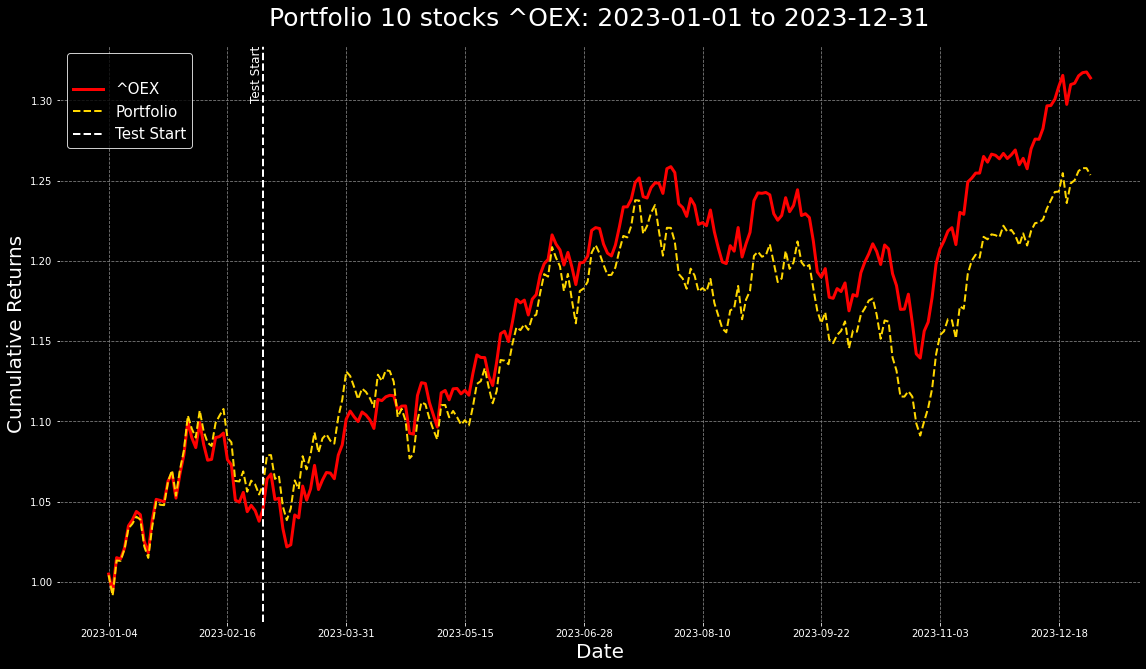

In [8]:
plot_portfolio(regular_sp100_10stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, sp100_index_ticker)

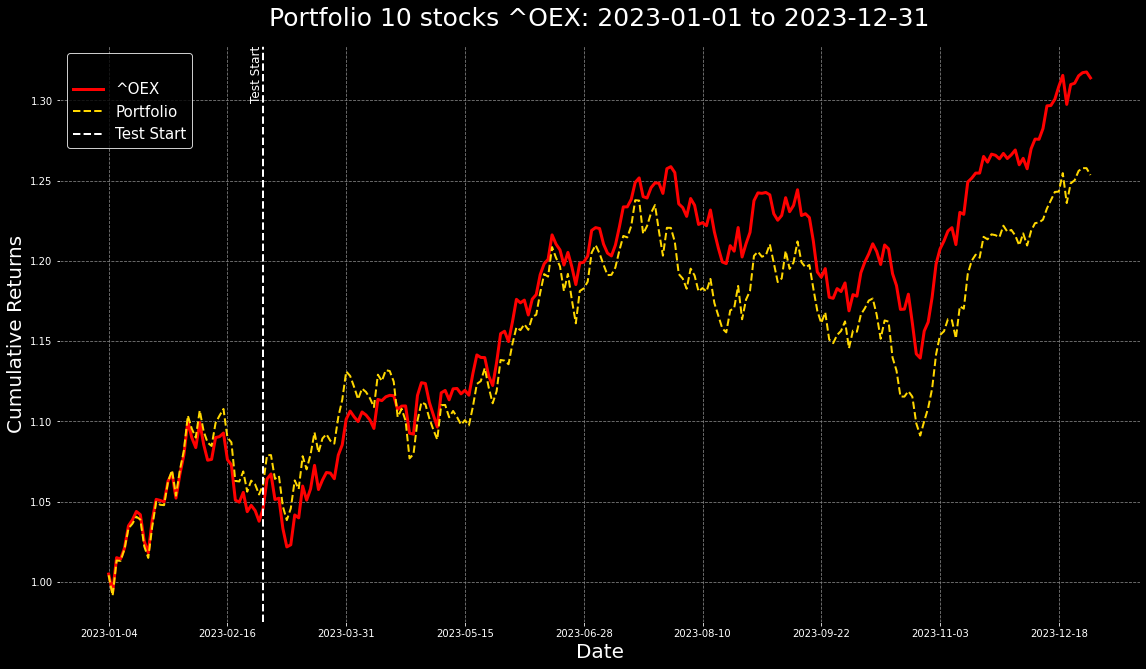

In [9]:
plot_portfolio(initial_sp100_10stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, sp100_index_ticker)

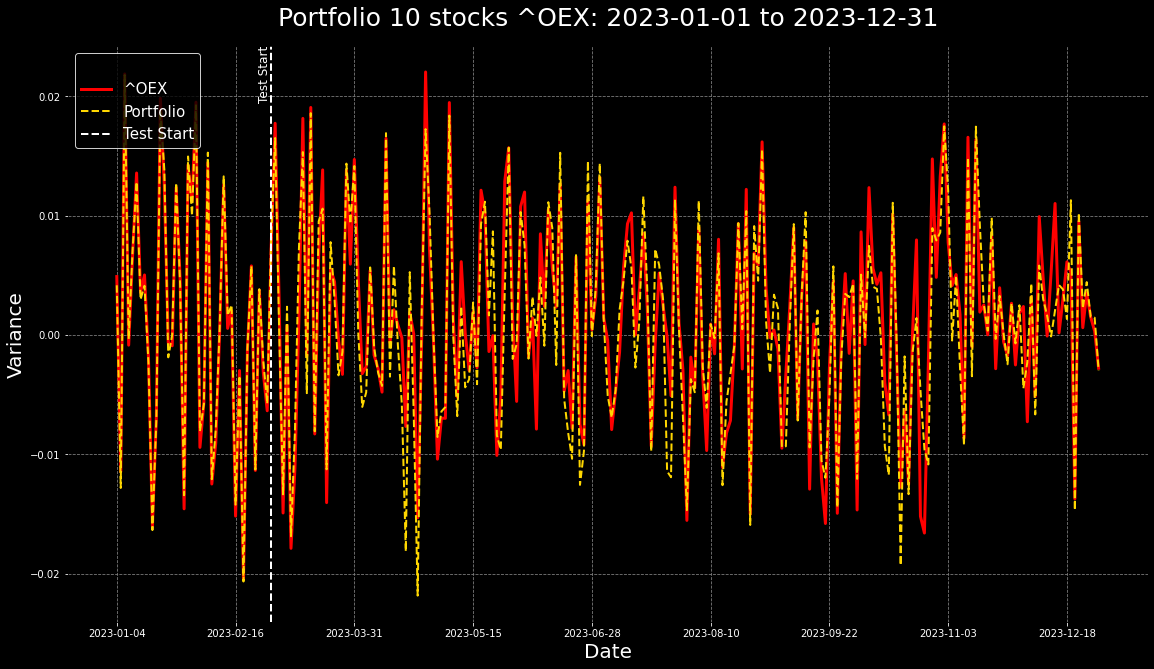

In [10]:
plot_portfolio(regular_sp100_10stocks, sp100_stock_variance, sp100_index_variance, start_date_dataset, end_date_dataset, sp100_index_ticker, 'Variance')

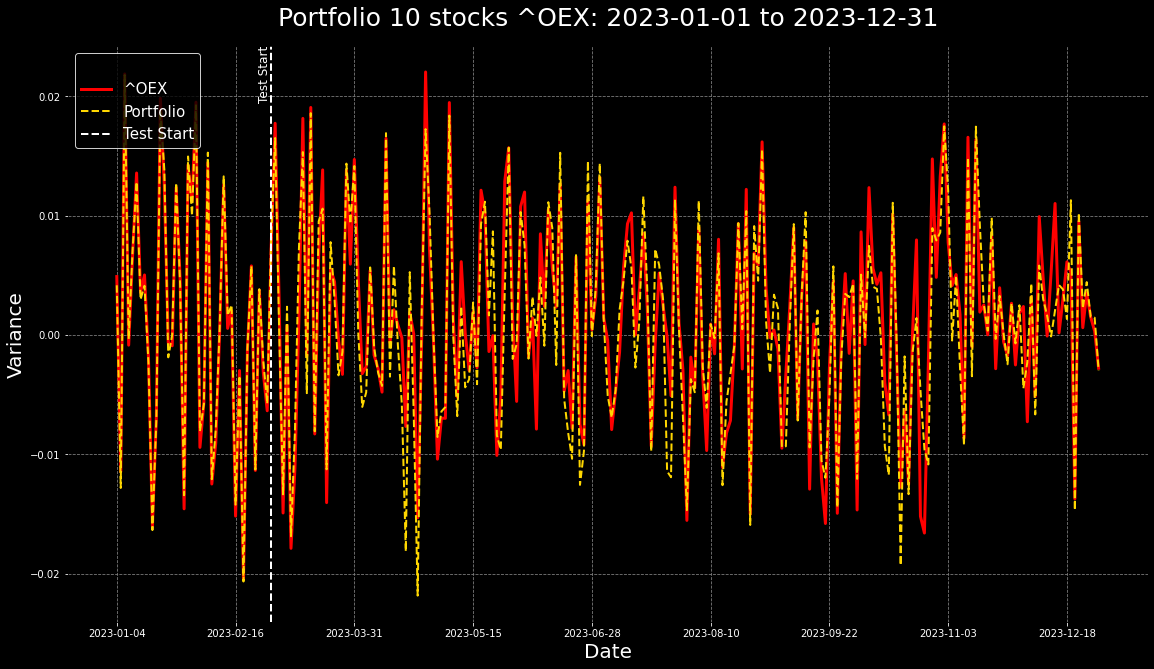

In [11]:
plot_portfolio(initial_sp100_10stocks, sp100_stock_variance, sp100_index_variance, start_date_dataset, end_date_dataset, sp100_index_ticker, 'Variance')

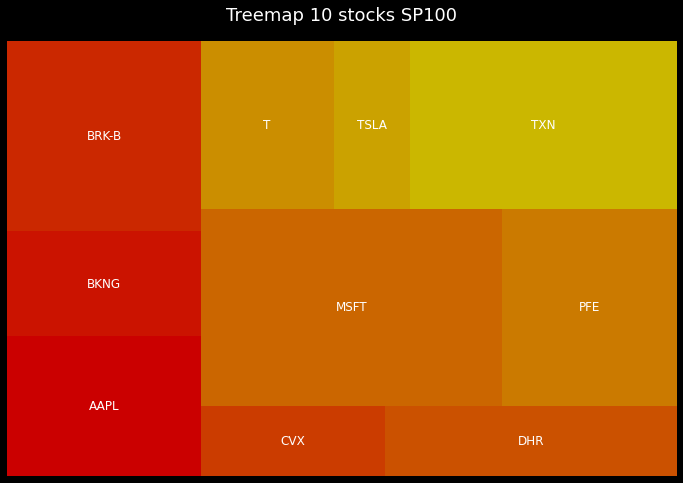

In [12]:
plot_weights(regular_sp100_10stocks['weights'])

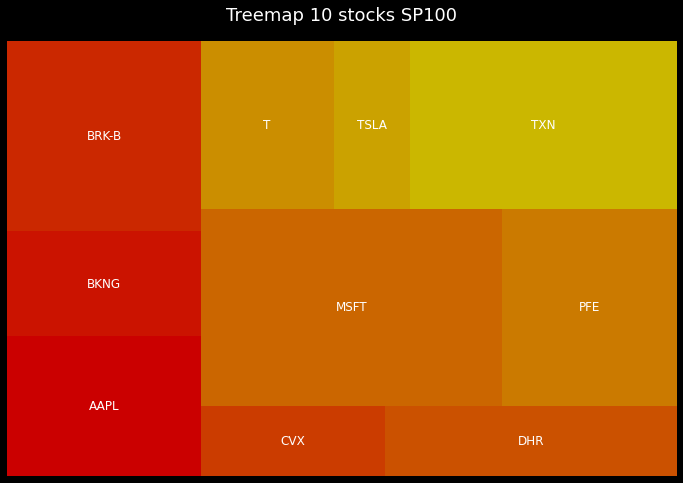

In [13]:
plot_weights(initial_sp100_10stocks['weights'])